# Resale data in Singapore - EDA

This notebook analyses the Resale data in Singapore from 1990 to 2021

The machine learning models is in the other notebooks: Resale Prices with lat lon and Resale price prediction

All data is available from data.gov.sg

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import os
%matplotlib inline

In [2]:
# more consistent as
path = 'resale-flat-prices'
files = os.listdir(path)


In [3]:
csv_files = [os.path.join(path,csv) for csv in files if ".csv" in csv if "resale-flat-prices" in csv ]
print(csv_files)

['resale-flat-prices\\resale-flat-prices-based-on-approval-date-1990-1999.csv', 'resale-flat-prices\\resale-flat-prices-based-on-approval-date-2000-feb-2012.csv', 'resale-flat-prices\\resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv', 'resale-flat-prices\\resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv', 'resale-flat-prices\\resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv']


## Preprocessing and cleaning

In [153]:
list_of_dataframes = [pd.read_csv(x, parse_dates = True) for x in csv_files]

In [154]:
#Combine 5 csv into one with concat
df = pd.concat(list_of_dataframes,ignore_index = True)
# view headers

In [155]:
df['month'] = df['month'].str.split('-').str[0].astype(int)
df = df.sort_values('month')

In [156]:
len(df)

881310

In [157]:
# split storey range into two columns with a low and high
df_storey =df['storey_range'].str.split(pat = " TO ", expand=True)
df_storey = df_storey.astype(int)
df_storey.head()

,0,1
0,10,12
8331,1,3
8332,4,6
8333,10,12
8334,10,12


In [158]:
storey_range= df_storey.mean(axis = 1)

In [159]:
# shows which floor is sold more often
# however not a very accurate representation as most flats were not high floors

print(storey_range.to_frame(0).groupby(0).size().sort_values(ascending = False))

0
5.0     222115
8.0     202856
2.0     178459
11.0    170273
14.0     57677
17.0     22109
20.0     10527
23.0      6943
26.0      3032
3.0       2700
29.0      1369
13.0      1259
32.0       492
35.0       456
38.0       428
18.0       265
41.0       209
44.0        46
47.0        40
28.0        39
50.0        14
33.0         2
dtype: int64


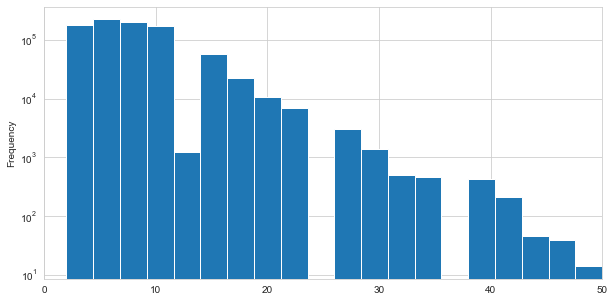

In [160]:
# hist plot, log scale due to the difference in values
storey_range.plot(kind= 'hist',log = True,xlim = (0,50),bins = 20,figsize = (10,5))
plt.show()

In [161]:
# Create target variable Dataframe
# Drop block, storey range and street name as irrelevant and difficult to work with
# Check .info() of features

price= df['resale_price']
features = df.drop(columns = ['block','storey_range','street_name'], axis = 1)
features = pd.concat([features,storey_range],axis=1)
features = features.rename(columns={0: "Storey"})
features.head()

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,Storey
0,1990,ANG MO KIO,1 ROOM,31.0,IMPROVED,1977,9000.0,NaN,11.0
8331,1990,KALLANG/WHAMPOA,2 ROOM,49.0,STANDARD,1970,19000.0,NaN,2.0
8332,1990,KALLANG/WHAMPOA,2 ROOM,48.0,STANDARD,1970,20000.0,NaN,5.0
8333,1990,KALLANG/WHAMPOA,3 ROOM,59.0,IMPROVED,1976,41800.0,NaN,11.0
8334,1990,KALLANG/WHAMPOA,3 ROOM,59.0,IMPROVED,1976,40000.0,NaN,11.0


In [162]:
features['flat_type'].unique()

array(['1 ROOM', '2 ROOM', '3 ROOM', 'EXECUTIVE', '4 ROOM', '5 ROOM',
       'MULTI GENERATION', 'MULTI-GENERATION'], dtype=object)

In [163]:
features['flat_type'] = features['flat_type'].map({'MULTI GENERATION': 'MULTI-GENERATION'}).fillna(features['flat_type'])
features['flat_type'].unique()

array(['1 ROOM', '2 ROOM', '3 ROOM', 'EXECUTIVE', '4 ROOM', '5 ROOM',
       'MULTI-GENERATION'], dtype=object)

In [164]:
# Check for NAN values

features.isna().sum()

month                       0
town                        0
flat_type                   0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        709050
Storey                      0
dtype: int64

### Dealing with NaN values

Remaining_lease has many NaN values. Instead of dropping it or imputing, it can be estimated with the difference in month and lease commencement date. This is also based on the assumption that the lease is 99 years long.

In [165]:
# Create new col remaining_lease_dt which is the difference between month and lease_commence_date
features['current_lease_year']=features['month']-features['lease_commence_date']
features['remaining_lease_year'] = 99-features['current_lease_year']

In [166]:
#Check if the values are same
features[~features['remaining_lease'].isna()].head()

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,Storey,current_lease_year,remaining_lease_year
660539,2015,YISHUN,4 ROOM,84.0,Simplified,1987,315000.0,71,2.0,28,71
668704,2015,BUKIT BATOK,4 ROOM,93.0,New Generation,1985,395000.0,68,8.0,30,69
668703,2015,BUKIT BATOK,4 ROOM,92.0,Model A2,1998,388888.0,81,8.0,17,82
668702,2015,BUKIT BATOK,4 ROOM,96.0,New Generation,1984,386000.0,68,5.0,31,68
668701,2015,BUKIT BATOK,4 ROOM,93.0,New Generation,1985,385000.0,68,5.0,30,69


In [167]:
features.drop(columns = ['remaining_lease']
                         ,axis=1
                        ,inplace = True)
features.head()

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,Storey,current_lease_year,remaining_lease_year
0,1990,ANG MO KIO,1 ROOM,31.0,IMPROVED,1977,9000.0,11.0,13,86
8331,1990,KALLANG/WHAMPOA,2 ROOM,49.0,STANDARD,1970,19000.0,2.0,20,79
8332,1990,KALLANG/WHAMPOA,2 ROOM,48.0,STANDARD,1970,20000.0,5.0,20,79
8333,1990,KALLANG/WHAMPOA,3 ROOM,59.0,IMPROVED,1976,41800.0,11.0,14,85
8334,1990,KALLANG/WHAMPOA,3 ROOM,59.0,IMPROVED,1976,40000.0,11.0,14,85


## Data analysis

## Annual trend in number of resales

In [168]:
count = features.groupby('month').agg({'town':'count'})
count = count.rename(columns={"town":"No of Resales"})
count

,No of Resales
month,
1990,12505
1991,12855
1992,14503
1993,18116
1994,26373
1995,27289
1996,34919
1997,31759
1998,51095


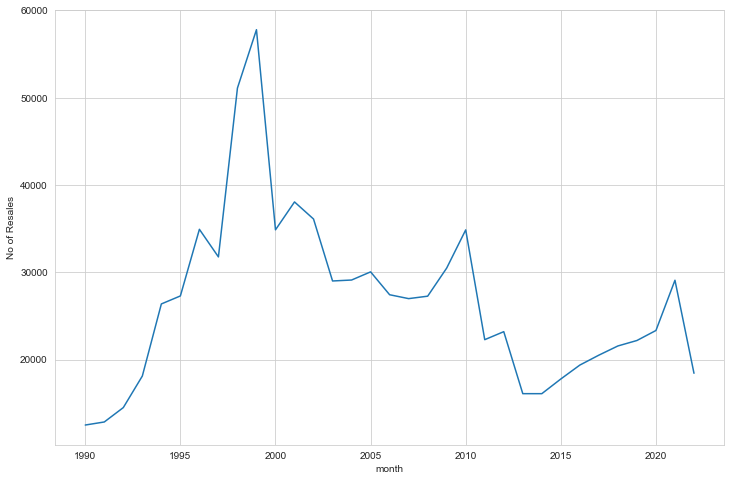

In [169]:
plt.figure(figsize = (12,8))
sns.lineplot(data=count,x='month',y='No of Resales')
plt.show()

## Median cost of housing from 1990

In [170]:
avg = features.groupby('month').agg({'resale_price':np.median})
avg.head()

,resale_price
month,
1990,52500.0
1991,57000.0
1992,64000.0
1993,103000.0
1994,152000.0


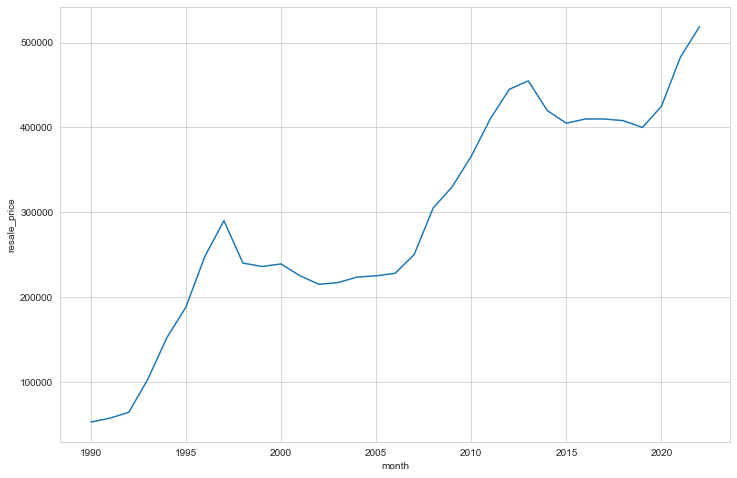

In [171]:
plt.figure(figsize = (12,8))
sns.lineplot(data=avg,x='month',y='resale_price')
plt.show()

# New Feature

Calculate prices with reference to inflation rate in Singapore. The CPI csv contains CPI up till Aug 2022.


In [172]:
cpi = pd.read_excel('cpiaug22.xlsx',sheet_name='T4',
                    skiprows = [0,1,2,3],
                    nrows= 2
                    )

In [173]:
transposed_cpi = cpi.transpose().iloc[1:,:]

In [174]:
transposed_cpi = transposed_cpi.rename(columns = {0:'Date',1:'Inflation'}).set_index('Date')
transposed_cpi.head(1)

,Inflation
Date,
1961 Jan,24.542


In [175]:
transposed_cpi.index = transposed_cpi.index.str.split(' ').str[0].astype(int)
transposed_cpi.head(1)

,Inflation
Date,
1961,24.542


In [176]:
inflation_df = transposed_cpi.groupby('Date').mean()

<AxesSubplot:xlabel='Date'>

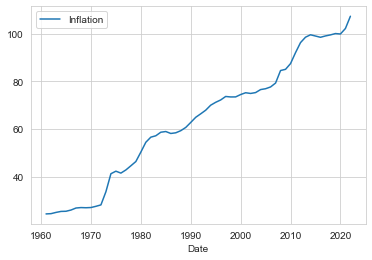

In [177]:
inflation_df.plot(kind='line',y = 'Inflation')

In [178]:
inflation_df.iloc[-1,0]

107.257125

In [179]:
# divide all values by the last inflation value given in 2022
# there is no need to multiply by hundred as this will make calculations easier in the adjustment
print(inflation_df.iloc[-1])
inflation_df['2022'] = inflation_df['Inflation'] / inflation_df.iloc[-1,0]
print(inflation_df.iloc[-1])

Inflation    107.257125
Name: 2022, dtype: float64
Inflation    107.257125
2022           1.000000
Name: 2022, dtype: float64


In [180]:
inflation_adjust = avg.join(inflation_df,how='right')
inflation_adjust.tail()

,resale_price,Inflation,2022
Date,,,
2018,408000.0,99.437917,0.927098
2019,400000.0,100.000000,0.932339
2020,425000.0,99.818083,0.930643
2021,483000.0,102.118750,0.952093
2022,518888.0,107.257125,1.000000


## CPI Adjustment

To adjust for inflation, we will take new_cpi / old_cpi

In [181]:
inflation_adjust['2022_dollars'] = inflation_adjust['resale_price'] / inflation_adjust['2022']

In [182]:
resale_pct_change = (inflation_adjust['2022_dollars'].pct_change()*100).dropna()

In [183]:
resale_pct_change

Date
1991     4.960931
1992     9.816490
1993    57.332211
1994    43.143030
1995    21.586911
1996    30.120496
1997    14.616693
1998   -17.016527
1999    -1.689428
2000    -0.076307
2001    -6.803148
2002    -4.068920
2003     0.441074
2004     1.302320
2005     0.201464
2006     0.366899
2007     7.388719
2008    14.416710
2009     7.554919
2010     7.846890
2011     6.452589
2012     3.787674
2013    -0.108846
2014    -8.628996
2015    -3.064828
2016     1.776291
2017    -0.572959
2018    -0.922379
2019    -2.511846
2020     6.443639
2021    11.086667
2022     2.283560
Name: 2022_dollars, dtype: float64

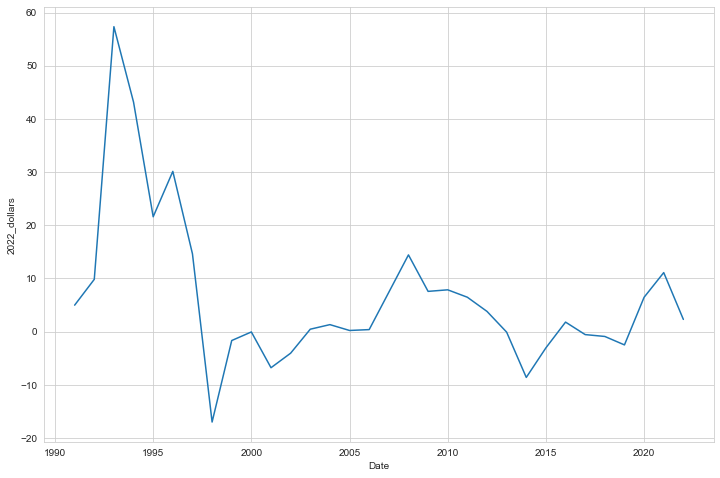

In [184]:
plt.figure(figsize = (12,8))
sns.lineplot(data = resale_pct_change,)
plt.show()

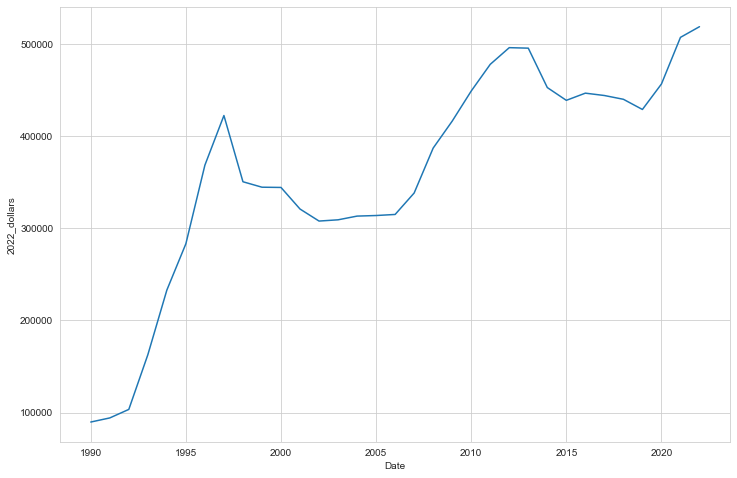

In [185]:
plt.figure(figsize = (12,8))
sns.lineplot(data=inflation_adjust,x='Date',y='2022_dollars')
plt.show()

In [186]:
inflation_mapper = inflation_df.iloc[:,1].copy().to_dict()
# This is for later use

In [187]:
inflation_mapper

{1961: 0.22750003787627163,
 1962: 0.22854503449848512,
 1963: 0.2333916433679037,
 1964: 0.23725851934467446,
 1965: 0.23786842443644968,
 1966: 0.24266686245785535,
 1967: 0.2505591120403423,
 1968: 0.25227073104312026,
 1969: 0.2516289710357237,
 1970: 0.2524696300284635,
 1971: 0.2572261127951484,
 1972: 0.26273545929932396,
 1973: 0.31427593582555313,
 1974: 0.38456574951702904,
 1975: 0.39447884386856974,
 1976: 0.3869976003925147,
 1977: 0.39933322222960316,
 1978: 0.4155667980099224,
 1979: 0.4322098259983505,
 1980: 0.46912423455939795,
 1981: 0.5075397089004575,
 1982: 0.5274257226889744,
 1983: 0.5328954447859137,
 1984: 0.5467717568102507,
 1985: 0.549459223959869,
 1986: 0.541873092347012,
 1987: 0.5444906340720954,
 1988: 0.5527845663710763,
 1989: 0.5654651536358695,
 1990: 0.5849735701318988,
 1991: 0.6050957764655108,
 1992: 0.6186737400118328,
 1993: 0.6328507313616695,
 1994: 0.6524352888755254,
 1995: 0.6636893974798099,
 1996: 0.6728418586022452,
 1997: 0.686454007

### Findings:

Despite calculating for inflation, it is observed that that were some big price jumps. It is unclear what happened in 1993 with the pct_change of 57%.


## Top 5 locations with resale flats since 1990

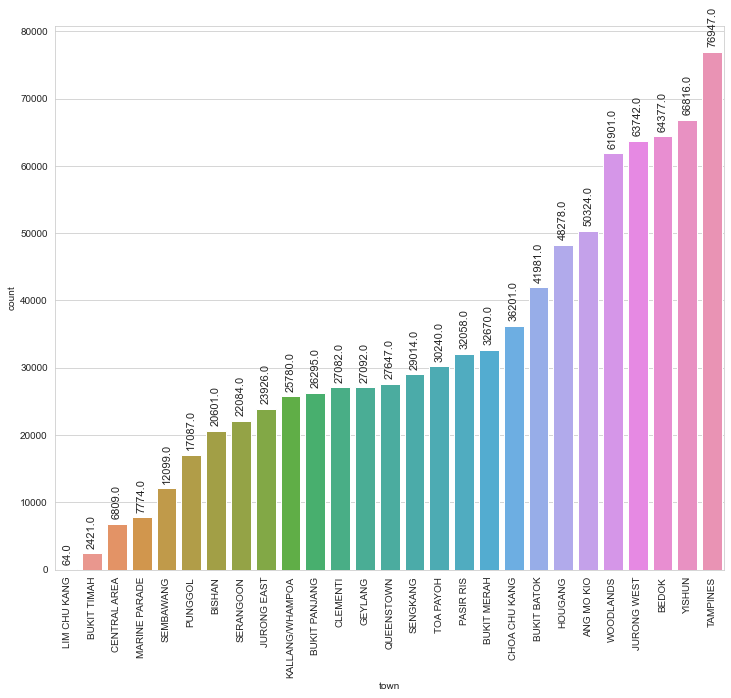

In [188]:
plt.figure(figsize = (12,10))
graph = sns.countplot(data=features,
                      x='town',
                      order=features['town'].value_counts(ascending=True).index)
plt.xticks(rotation=90)
for p in graph.patches:
    graph.annotate(format(p.get_height()), (p.get_x()+0.2, p.get_height()+1000),
                  rotation=90,
                  fontsize=11)

## Histogram plot of remaining lease

From the plot we can see most of the houses sold were right after the Minumum occupancy period of 5 years.

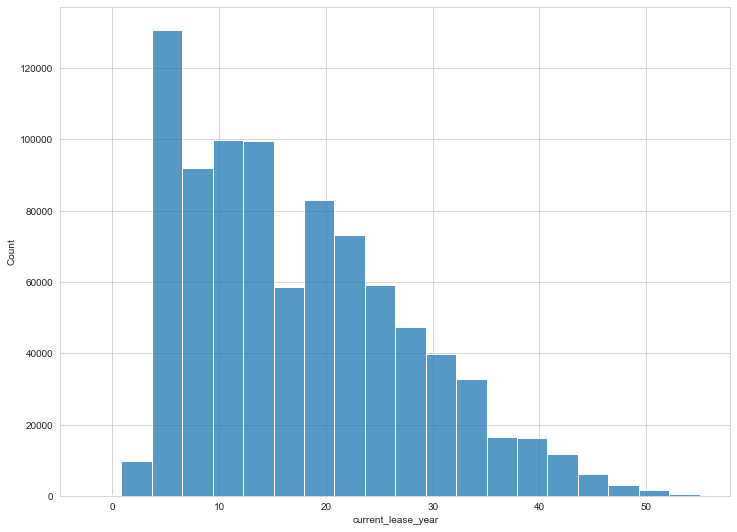

In [189]:
plt.figure(figsize = (12,9))
graph = sns.histplot(data=features,
                    x='current_lease_year',
                    bins=20)

### Flat types

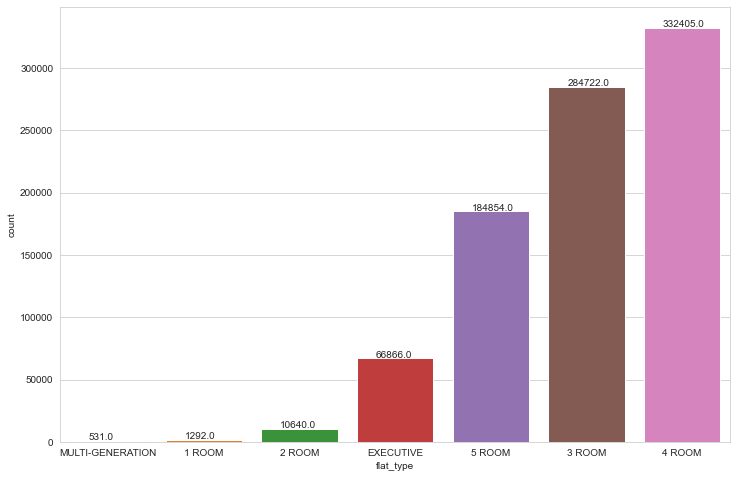

In [190]:
plt.figure(figsize = (12,8))
graph = sns.countplot(data=features,
                      x='flat_type',
                      order=features['flat_type'].value_counts(ascending=True).index)
for p in graph.patches:
    graph.annotate(format(p.get_height()), (p.get_x()+0.2, p.get_height()+1000))

## Trend of resales right after MOP. 

I use the value 93 to filter out remaining leases below 93. The assumption of 2 years is for searching of buyers and the time required to process the transaction. 

In [191]:
mop_resale = features[features['remaining_lease_year']>93]
len(mop_resale) # Show number of total resales with lease above 93

104607

In [192]:
mop_resale = mop_resale.groupby('month').agg({'town':'count'})

In [193]:
mop_resale.sort_values(by='town',ascending=False).head(5) # Resample to annual and sum it up

,town
month,
2001,9861
2002,8677
1999,8504
2000,6827
1998,6281


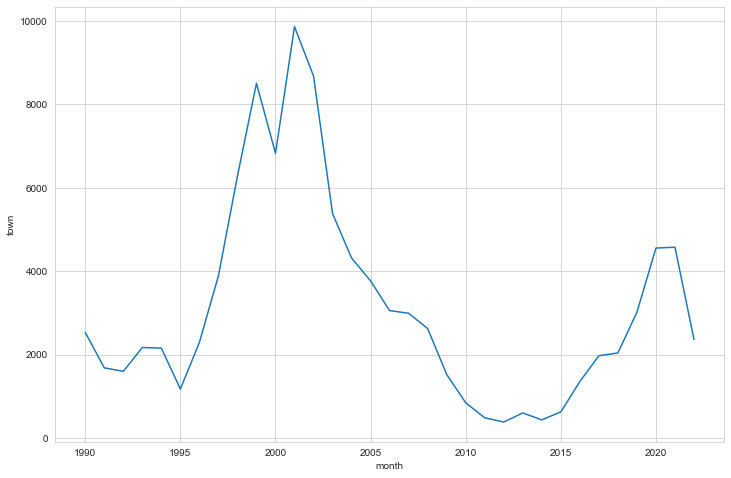

In [194]:
plt.figure(figsize = (12,8))
sns.lineplot(data=mop_resale,x='month',y='town')
plt.show()

From the above graph and data, the top 5 sales in MOP occured in 1998-2002 inclusive. After decreasing from 2001 till 2015, it begun to rise again. More data is needed to see if the trend is continuing. 

## Flat by age

### hist plot of all flat age

In [195]:
features['age'] = datetime.now().year-features['lease_commence_date']

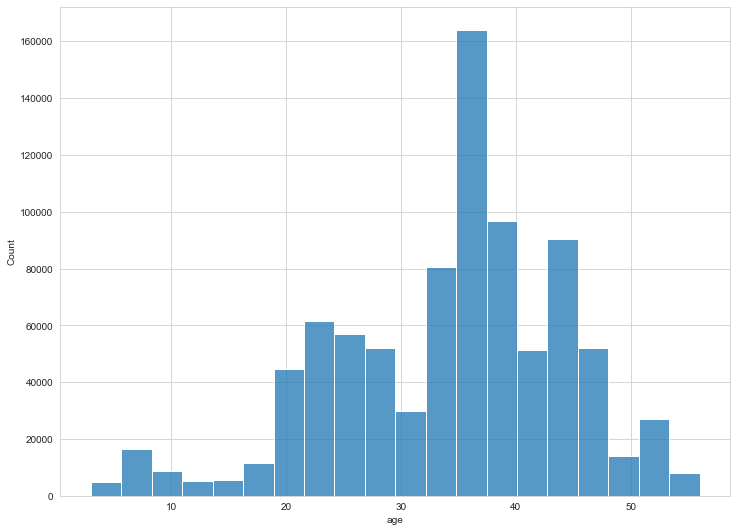

In [196]:
plt.figure(figsize = (12,9))
graph = sns.histplot(data=features,
                    x='age',
                    bins=20)

### Age by town

In [197]:
avg_town_age= features.groupby('town')['age'].median()
avg_town_age = avg_town_age.to_frame()
avg_town_age.sort_values(by='age',ascending=False).head(5)

,age
town,
QUEENSTOWN,48.0
TOA PAYOH,47.0
MARINE PARADE,47.0
BUKIT MERAH,44.0
CLEMENTI,43.0


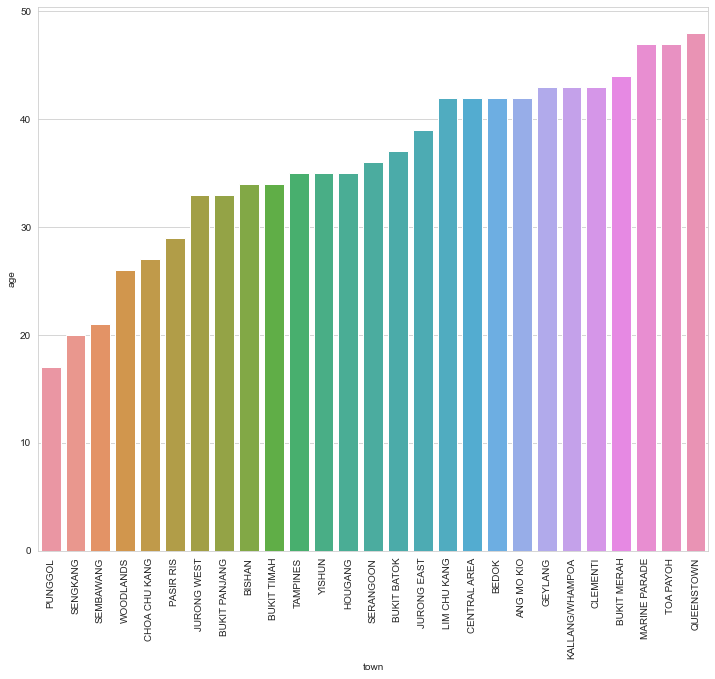

In [198]:
plt.figure(figsize = (12,10))
sns.barplot(data=avg_town_age,
            x=avg_town_age.index,
            y ='age',
            order=avg_town_age.sort_values(by='age',ascending=True).index)
plt.xticks(rotation=90)
plt.show()

## Analysis by town prices with inflation adjustment

In [200]:
features['adj'] = features['resale_price'].divide(features['month'].map(inflation_mapper)).round()

In [201]:
features.tail()

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,Storey,current_lease_year,remaining_lease_year,age,adj
816817,2022,TAMPINES,4 ROOM,104.0,Model A,1989,540000.0,11.0,33,66,33,540000.0
816816,2022,TAMPINES,4 ROOM,104.0,Model A,1988,540000.0,5.0,34,65,34,540000.0
816815,2022,TAMPINES,3 ROOM,74.0,Model A,1988,365000.0,2.0,34,65,34,365000.0
816821,2022,TAMPINES,4 ROOM,104.0,Model A,1988,510000.0,2.0,34,65,34,510000.0
821281,2022,TAMPINES,5 ROOM,107.0,DBSS,2011,828000.0,8.0,11,88,11,828000.0


In [205]:
avg_town= features.groupby('town')['adj'].mean()
avg_town = avg_town.to_frame()
avg_town = avg_town.rename(columns={"adj": "Avg Resale"})
avg_town = avg_town.round(0)
avg_town.sort_values(by = 'Avg Resale', ascending=False).head(5)

,Avg Resale
town,
BUKIT TIMAH,564427.0
BISHAN,536497.0
PASIR RIS,519079.0
PUNGGOL,509449.0
SENGKANG,479667.0


In [206]:
med_town= features.groupby('town')['adj'].median()
med_town = med_town.to_frame()
med_town = med_town.rename(columns={"adj": "Med Resale"})
med_town = med_town.round(0)
med_town.sort_values(by = 'Med Resale', ascending=False).head(5)

,Med Resale
town,
BUKIT TIMAH,555000.0
BISHAN,526373.0
PASIR RIS,503832.0
PUNGGOL,502052.0
SENGKANG,473866.0


In [207]:
count_town= features.groupby('town')['adj'].count()
count_town = count_town.to_frame()
count_town = count_town.rename(columns={"adj": "Count Resale"})
count_town = count_town.round(0)
count_town.sort_values(by = 'Count Resale', ascending=False).head(5)

,Count Resale
town,
TAMPINES,76947
YISHUN,66816
BEDOK,64377
JURONG WEST,63742
WOODLANDS,61901


### Highest price based on flat type and flat model, followed by average thereafter

In [208]:
max_features =features.groupby(['flat_type','flat_model'])['adj'].max()
df_max= max_features.to_frame()
df_max = df_max.round(0)
df_max.sort_values(by = 'adj', ascending=False).head(10)

adj
flat_type flat_model                       
5 ROOM    DBSS                    1428432.0
          Premium Apartment Loft  1418000.0
          Improved                1400000.0
          Type S2                 1388889.0
EXECUTIVE MAISONETTE              1337610.0
3 ROOM    Terrace                 1331803.0
EXECUTIVE APARTMENT               1312344.0
          Maisonette              1300293.0
          Apartment               1297142.0
4 ROOM    Type S1                 1275342.0

In [209]:
# Shows the mean price based on flat type and flat model
mean_features =features.groupby(['flat_type','flat_model'])['adj'].mean()
df_mean= mean_features.to_frame()
df_mean = df_mean.round(0)
df_mean.sort_values(by = 'adj', ascending=False).head(10)

adj
flat_type flat_model                       
5 ROOM    Type S2                 1125388.0
EXECUTIVE PREMIUM APARTMENT       1018070.0
5 ROOM    Premium Apartment Loft   999714.0
4 ROOM    Type S1                  993536.0
          Premium Apartment Loft   961629.0
5 ROOM    DBSS                     910203.0
EXECUTIVE Premium Maisonette       775880.0
4 ROOM    Terrace                  770576.0
3 ROOM    Terrace                  750637.0
4 ROOM    DBSS                     739753.0